# Systems of Nonlinear Equations

This code is to help us visualize the solution of nonlinear linear equations. <br>

This tutorial can be deployed in <a target="_blank" href="https://colab.research.google.com/github/ChemAI-Lab/Math4Chem/blob/main/website/Lecture_Notes/Coding/nonlinear_equations.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

We will start first with a review of linear regression but solved using an iterative search approach.<br>


Here we define the a dummy linear model,
$$
f(\mathbf{w},x) = \begin{bmatrix}
b, & a \end{bmatrix}  \begin{bmatrix}
1 \\
 x \\
\end{bmatrix}
$$

As we will see, the parameters of the linear model, $\mathbf{w}^top=[a,b]$, are *free parameters*. Meaning, we usually use a metric function, commonly named to **loss function**, to search for the **optimal parameters**.<br>

. The loss function measures the distance between the predicted values, $f(x,\mathbf{w})$, and true values, $\hat{y}$,. <br>

# Least Squares
As we saw in clasee, the least squares problem can be described using the matrix notation,
$$

 {\cal L}(\mathbf{w}) =  \frac{1}{2n}\left ( \mathbf{Y} - \mathbf{X} \mathbf{w} \right )^\top \left ( \mathbf{Y} - \mathbf{X} \mathbf{w} \right )= \frac{1}{2n} \left (\mathbf{Y}^\top \mathbf{Y} - 2\mathbf{Y}^\top\mathbf{X} \mathbf{w}  + \mathbf{w}^\top \mathbf{X}^\top\mathbf{X} \mathbf{w} \right )
$$

In [1]:
# when deployed in Colab uncomment this line to install ipyml
#!pip install ipympl 

In [2]:
%matplotlib widget 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.tri as tri

rng1 = np.random.default_rng(1)

In [3]:
x = np.linspace(0, 2, 10)
X = np.column_stack((np.ones_like(x), x))
y = X@np.array([1, 2]) + rng1.uniform(-0.75, 0.75, size=x.shape)  # add some noise

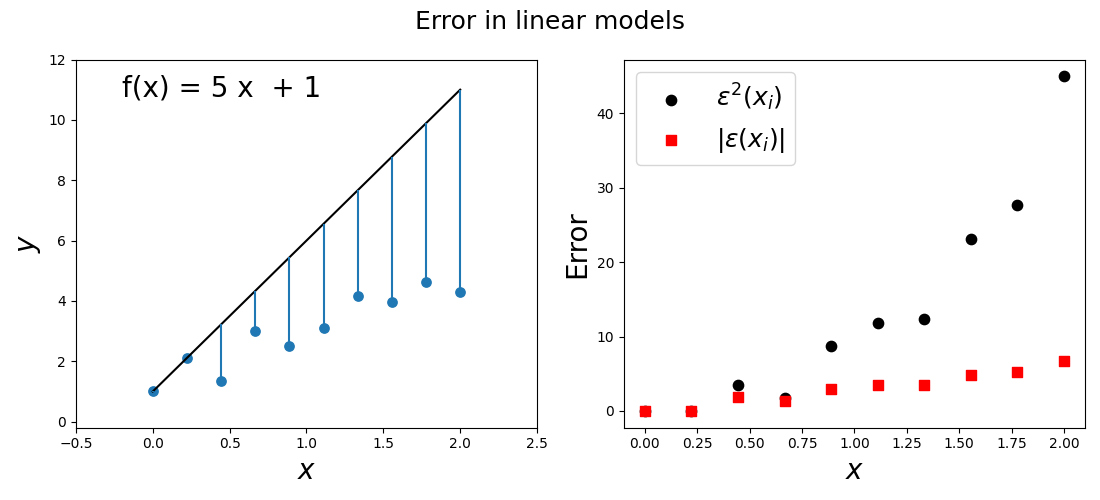

In [4]:
# change the values of a and b and see what happens
a = 5
b = 1
w = np.array([b,a])

x_grid = np.linspace(0, 2, 100)
X_grid = np.column_stack((np.ones_like(x_grid), x_grid))
y_grid = X_grid@w

y_pred = X@w # calculate values of training data
error = y_pred - y

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(11,5))
fig.suptitle('Error in linear models',fontsize=18)

# left panel 
ax1.plot(x_grid, y_grid, c='k')
for xi, yi in zip(x, y):
    y_pred_i = np.array([1,xi])@w
    error_i = yi - y_pred_i
    if error_i > 0:
        ax1.vlines(xi, y_pred_i, y_pred_i + np.abs(error_i))
    else:
        ax1.vlines(xi, y_pred_i - np.abs(error_i), y_pred_i)
ax1.text(0.1, .9, f'f(x) = {a} x  + {b}', fontsize=20, transform=ax1.transAxes)
ax1.scatter(x, y, s=45)
ax1.set_xlim(-0.5, 2.5)
ax1.set_ylim(-2, 12)
ax1.set_ylabel(r'$y$', fontsize=20)
ax1.set_xlabel(r'$x$', fontsize=20)

# right panel
sum_errors = 0.
for i,(xi, yi) in enumerate(zip(x, y)):
    y_pred_i = np.array([1, xi])@w
    error_i = yi - y_pred_i
    sum_errors += error_i**2

    if i == x.shape[0]-1:
        ax2.scatter(xi, error_i**2, color='k', s=55,label=r'$\epsilon^2(x_i)$')
        ax2.scatter(xi, np.abs(error_i), color='r', s=55, marker='s',label=r'$|\epsilon(x_i)|$')   
    else:
        ax2.scatter(xi, error_i**2, color='k', s=55)
        ax2.scatter(xi, np.abs(error_i), color='r', s=55, marker='s')
    

ax2.set_ylabel(r'Error', fontsize=20)
ax2.set_xlabel(r'$x$', fontsize=20)

ax1.set_ylim(-0.2,12)
plt.legend(loc=0, fontsize=18)
plt.tight_layout()


Then we will proceed to compute the Jacobian of ${\cal L}(\mathbf{w})$ with respect to the parameters of the model, $\mathbf{w}^\top = [b,a]$,
$$
 \frac{\partial }{\partial \mathbf{w}}{\cal L}(\mathbf{w}) = \frac{1}{2n} \frac{\partial }{\partial \mathbf{w}}\left (\mathbf{Y}^\top \mathbf{Y} - 2\mathbf{Y}^\top\mathbf{X} \mathbf{w}  + \mathbf{w}^\top \mathbf{X}^\top\mathbf{X} \mathbf{w} \right )
$$
which give us three unique terms,
$$
\frac{\partial }{\partial \mathbf{w}} \mathbf{Y}^\top \mathbf{Y} = \mathbf{0} \\
\frac{\partial }{\partial \mathbf{w}} \mathbf{Y}^\top\mathbf{X} \mathbf{w} = \mathbf{z} = \mathbf{X}^\top  \mathbf{Y}\\
\frac{\partial }{\partial \mathbf{w}}\mathbf{w}^\top \mathbf{X}^\top\mathbf{X} \mathbf{w} = 2 \mathbf{X}^\top\mathbf{X}\mathbf{w}
$$

If we combine these three equations and we set the Jacobian to zero, we  get,
$$
 \frac{\partial }{\partial \mathbf{w}}{\cal L}(\mathbf{w}) = \frac{1}{n} \left (- \mathbf{X}^\top  \mathbf{Y}  + \mathbf{X}^\top\mathbf{X} \mathbf{w} \right ),
$$


In [5]:
# gradient
def gradient_w(w0,x,y):
    w = - x.T@y 
    w = w + x.T@x@w0
    return w/x.shape[0]

def loss_function(w0,x,y):
    y_pred = x@w0
    loss = 0.5 * np.mean((y_pred - y)**2)
    return loss



In [6]:
def linear_model_solver(X, y):
    Xt = X.T
    A = Xt@X
    z = Xt@y
    A_inv = np.linalg.inv(A)
    w = A_inv@z
    return w  # optimal parameters

w_opt = linear_model_solver(X,y)
e_opt = loss_function(w_opt,X,y)
print(w_opt)

[1.26480696 1.75083907]


# Gradient Descent
Is a search method, used to find the minimum and maximum of functions using the gradient of a function.<br>
The central point in gradient descent is **direction of largest decrease is** $-\frac{\partial f}{\partial x}$ (the negative gradient of a function.)<br>

The general equation for gradient descent is,
$$
\mathbf{w}_{new} = \mathbf{w} - \eta \nabla_{\mathbf{w}} {\cal L}(\mathbf{w})
$$
where $\eta$ is the learning rate, and $\nabla_{\mathbf{w}} {\cal L}(\mathbf{w})$ is the gradient|.

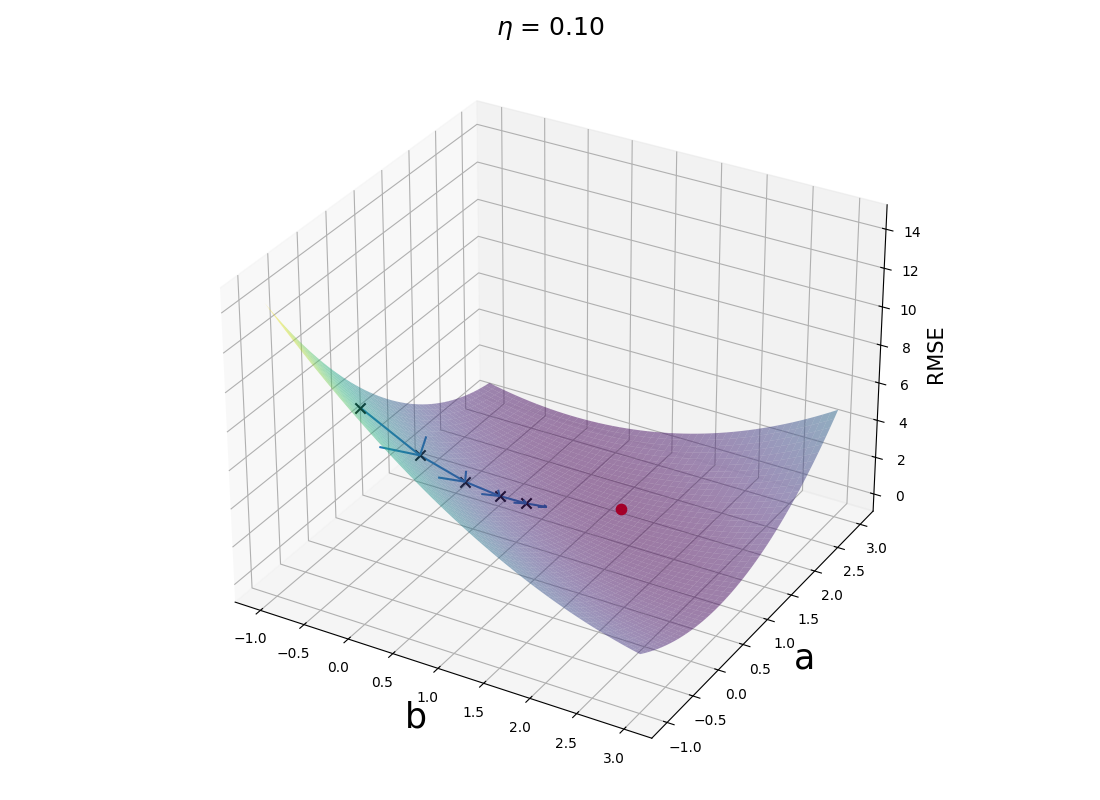

In [7]:
a_grid = np.linspace(-1, 3, 50)
b_grid = np.linspace(-1, 3, 50)
a_, b_ = np.meshgrid(a_grid, b_grid)
w_ = np.column_stack((b_.flatten(), a_.flatten()))

total_error_ = []
for wi in w_:
    ei = loss_function(wi, X, y)
    total_error_.append(ei)
total_error_ = np.array(total_error_)
total_error_ = total_error_.reshape(a_.shape)


plt.figure(figsize=(11, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(b_, a_, total_error_, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', alpha=0.5)

eta = 0.1
w_random = rng1.normal(-0.5, 0.5, size=(2,))
# w_random = np.ones((2,))
ax.set_title(r'$\eta$ = ' + f'{eta:.2f}',fontsize=18)

for i in range(5):
    e = loss_function(w_random,X,y)
    dw = gradient_w(w_random, X, y)
    w_new = w_random - eta*dw
    e_new = loss_function(w_new,X,y)
    ax.quiver(w_random[0], w_random[1], e, w_new[0]-w_random[0],
            w_new[1]-w_random[1], e_new-e)
    ax.scatter(w_random[0], w_random[1], e, marker='x', s=55,color='k')
    w_random = w_new

ax.scatter(w_opt[0], w_opt[1], e_opt, marker='o', s=55, color='r')
ax.set_xlabel('b', fontsize=25)
ax.set_ylabel('a', fontsize=25)
ax.set_zlabel('RMSE', fontsize=15, rotation=90)
# ax.view_init(elev=30, azim=-120)
plt.tight_layout()

In [8]:

def get_grad_trajectory(eta,n_itr):
    # w = np.random.normal(-5, 5, size=(2,))
    w = np.random.uniform(-1, 2, size=(2,))
    # w = np.ones((2,))
    w_tr = w[None, :]
    for i in range(n_itr):
        dw = gradient_w(w, X, y)
        e = loss_function(w, X, y)
        w = w - eta * dw
        w_tr = np.vstack((w_tr, w))
    return w_tr


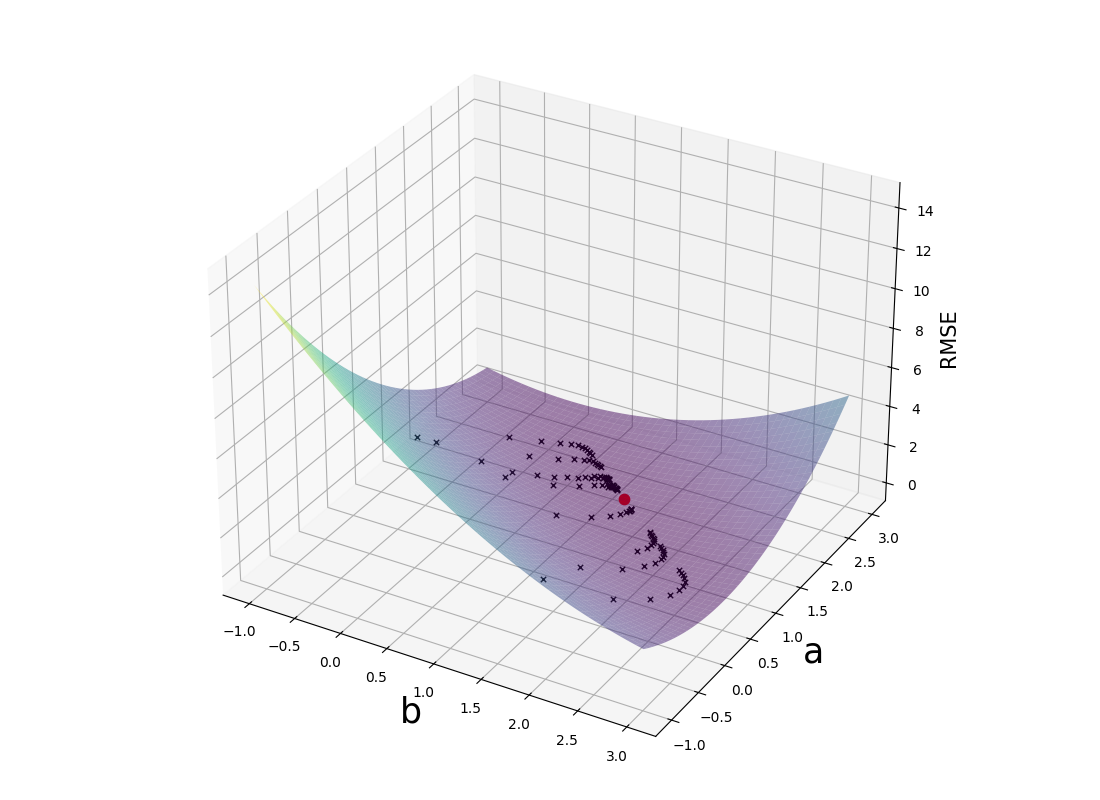

In [9]:
a_grid = np.linspace(-1, 3, 50)
b_grid = np.linspace(-1, 3, 50)
b_, a_ = np.meshgrid(a_grid, b_grid)
w_ = np.column_stack((b_.flatten(), a_.flatten()))

total_error_ = []
for wi in w_:
    ei = loss_function(wi, X, y)
    total_error_.append(ei)
total_error_ = np.array(total_error_)
total_error_ = total_error_.reshape(a_.shape)

eta = 0.2
n_itr = 10

plt.figure(figsize=(11, 8))
ax = plt.axes(projection='3d')
ax.plot_surface(b_, a_, total_error_, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none',alpha=0.5)

# random initialization
for i in range(10):
    w_tr = get_grad_trajectory(eta,n_itr)
    for wi in w_tr:
        ax.scatter(wi[0], wi[1], loss_function(wi, X,y),
            zorder=10, color='k', marker='x', s=15,linewidths=1.)  # + 1E-3 is only for display

ax.scatter(w_opt[0], w_opt[1], e_opt, marker='o', s=55, color='r')
ax.set_xlabel('b', fontsize=25)
ax.set_ylabel('a', fontsize=25)
ax.set_zlabel('RMSE', fontsize=15, rotation=90)
# ax.view_init(elev=30, azim=-120)
plt.tight_layout()

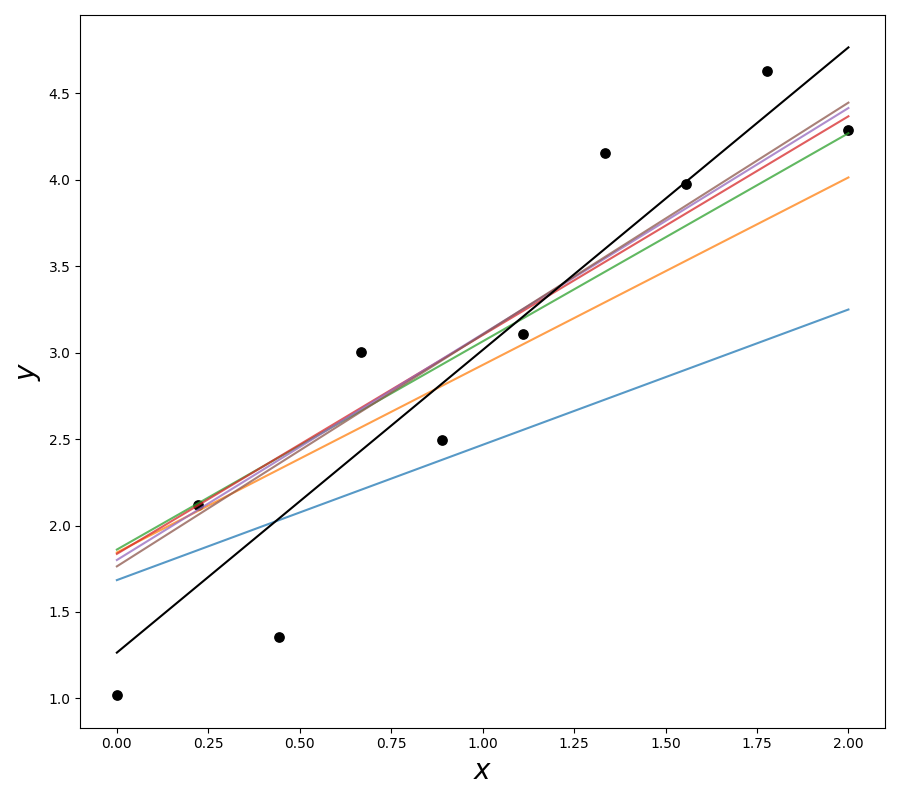

In [13]:
# change the values of a and b and see what happens
x_grid = np.linspace(0, 2, 100)
X_grid = np.column_stack((np.ones_like(x_grid), x_grid))

eta = 0.2
n_itr = 10
w_tr = get_grad_trajectory(eta,n_itr)
 
fig, (ax1) = plt.subplots(1, 1, figsize=(9, 8))

# left panel
for i,wi in enumerate(w_tr[::2]):
    y_pred = X_grid@wi
    ax1.plot(x_grid, y_pred, alpha=0.75,label=f'{i}')

ax1.plot(x_grid, X_grid@w_opt, c='k')
ax1.scatter(x, y, c='k', s=45)

ax1.set_ylabel(r'$y$', fontsize=20)
ax1.set_xlabel(r'$x$', fontsize=20)

# ax1.set_ylim(-0.2, 12)
# plt.legend(loc=0, fontsize=18)
plt.tight_layout()